In [92]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from arch import arch_model

import warnings
warnings.simplefilter(action='ignore', category=Warning)

# Return Forecasting: Time Series Analysis & Modelling with CAD-PHY Exchange rate data.
In this notebook, you will load historical Canadian Dollar-Yen exchange rate futures data and apply time series analysis and modeling to determine whether there is any predictable behavior.

In [4]:
# Currency pair exchange rates for CAD/JPY
cad_jpy_df = pd.read_csv(
    Path("../Resources/cad_jpy.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
cad_jpy_df.head()

,Price,Open,High,Low
Date,,,,
1982-01-05,184.65,184.65,184.65,184.65
1982-01-06,185.06,185.06,185.06,185.06
1982-01-07,186.88,186.88,186.88,186.88
1982-01-08,186.58,186.58,186.58,186.58
1982-01-11,187.64,187.64,187.64,187.64


In [5]:
# Trim the dataset to begin on January 1st, 1990
cad_jpy_df = cad_jpy_df.loc["1990-01-01":, :]
cad_jpy_df.head()

,Price,Open,High,Low
Date,,,,
1990-01-02,126.37,126.31,126.37,126.31
1990-01-03,125.30,125.24,125.30,125.24
1990-01-04,123.46,123.41,123.46,123.41
1990-01-05,124.54,124.48,124.54,124.48
1990-01-08,124.27,124.21,124.27,124.21


# Initial Time-Series Plotting

 Start by plotting the "Settle" price. Do you see any patterns, long-term and/or short?

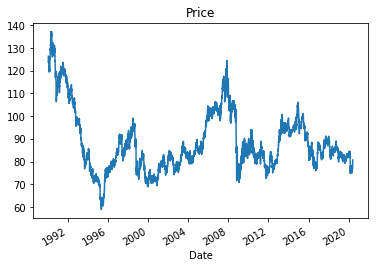

In [6]:
# Plot just the "Price" column from the dataframe:
cad_jpy_df['Price'].plot(title="Price");

**Question:** Do you see any patterns, long-term and/or short? 

**Answer:** There is no outstanding patterns, one that could possibly be noticed is. Over a four year period it rises then hits a peak then follows to crash rapidly soon after. It seems to have had a major crash and now with some volatility but seems to be returning to similar price.

---

# Decomposition Using a Hodrick-Prescott Filter

 Using a Hodrick-Prescott Filter, decompose the exchange rate price into trend and noise.

In [7]:
# Apply the Hodrick-Prescott Filter by decomposing the exchange rate price into two separate series:
cad_jpy_noise, cad_jpy_trend = sm.tsa.filters.hpfilter(cad_jpy_df['Price'])

In [8]:
# Create a dataframe of just the exchange rate price, and add columns for "noise" and "trend" series from above:
cad_jpy_erp = cad_jpy_df['Price'].to_frame()
cad_jpy_erp['noise'] = cad_jpy_noise.to_frame()
cad_jpy_erp['trend'] = cad_jpy_trend.to_frame()
cad_jpy_erp.head()

,Price,noise,trend
Date,,,
1990-01-02,126.37,0.519095,125.850905
1990-01-03,125.30,-0.379684,125.679684
1990-01-04,123.46,-2.048788,125.508788
1990-01-05,124.54,-0.798304,125.338304
1990-01-08,124.27,-0.897037,125.167037


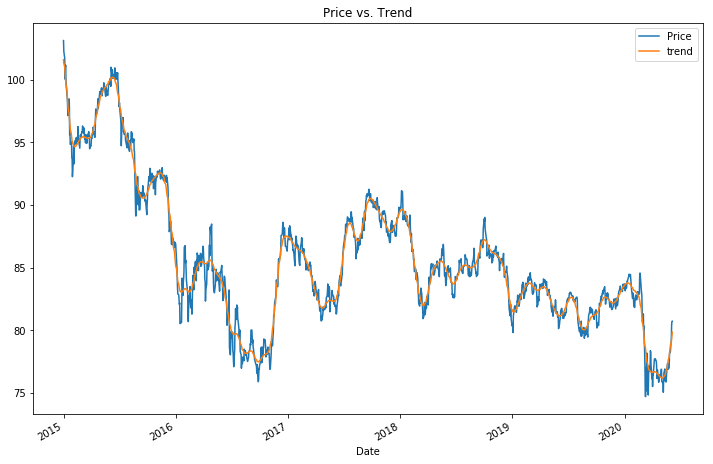

In [9]:
plot_df = cad_jpy_erp['Price'].to_frame()
plot_df['Price'] = plot_df.loc['2015':]
plot_df['trend'] = cad_jpy_trend.loc['2015':].to_frame()
plot_df.plot(title="Price vs. Trend", figsize=(12,8))

In [114]:
cad_jpy_erp["2015":, :].plot() 

TypeError: '(slice('2015', None, None), slice(None, None, None))' is an invalid key

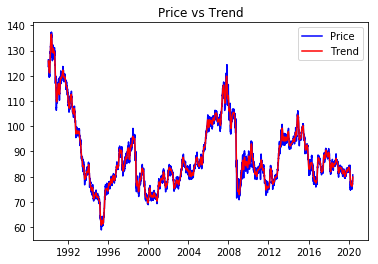

In [82]:
plot_df = cad_jpy_erp['Price'].to_frame()
plot_df['Price'] = plot_df.loc['2015':]
plot_df['trend'] = cad_jpy_trend.loc['2015':].to_frame()
# Plot a simple line chart
plt.plot(cad_jpy_erp.index, cad_jpy_erp['Price'], color='b', label='Price')

# Plot another line on the same chart/graph
plt.plot(cad_jpy_erp.index, cad_jpy_erp['trend'], color='r', label='Trend')

plt.title("Price vs Trend")
plt.legend()
plt.show()

<AxesSubplot:title={'center':'Price vs. Trend'}, xlabel='Date'>

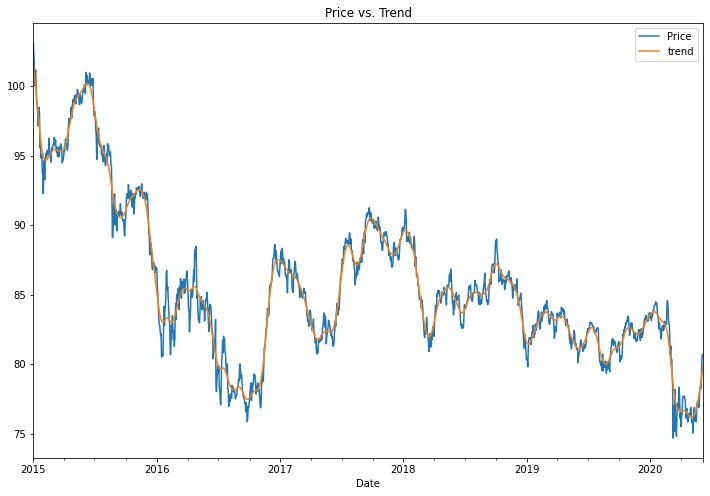

In [21]:
# Plot the Exchange Rate Price vs. the Trend for 2015 to the present


**Question:** Do you see any patterns, long-term and/or short?

**Answer:** Only short term pattern that is possible to see is that towards the end of the increase, there is a largest spike then a large decline nearly every time. Over long term no patterns just 

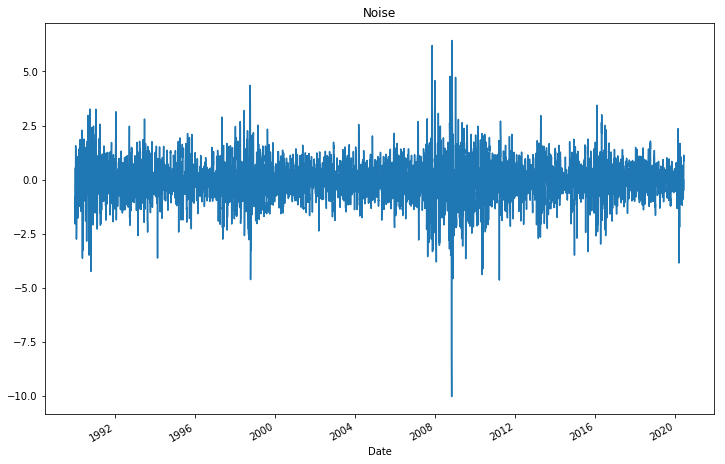

In [68]:
# Plot the Settle Noise
cad_jpy_erp['noise'].plot(title="Noise", figsize=(12,8));

---

# Forecasting Returns using an ARMA Model

Using exchange rate *Returns*, estimate an ARMA model

1. ARMA: Create an ARMA model and fit it to the returns data. Note: Set the AR and MA ("p" and "q") parameters to p=2 and q=1: order=(2, 1).
2. Output the ARMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the forecasted returns (the results forecast from ARMA model)

In [89]:
# Create a series using "Price" percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
cad_jpy_returns = (cad_jpy_df[["Price"]].pct_change() * 100)
cad_jpy_returns = cad_jpy_returns.replace(-np.inf, np.nan).dropna()
cad_jpy_returns.tail()

,Price
Date,
2020-05-29,0.076697
2020-06-01,1.251756
2020-06-02,1.425508
2020-06-03,0.373134
2020-06-04,0.012392


In [73]:
# Testing to see if the data is stationary or non-stationary 
adfuller(cad_jpy_returns.Price)

(-19.003863795444353,
 0.0,
 23,
 7904,
 {'1%': -3.4311776094390547,
  '5%': -2.861905743461419,
  '10%': -2.5669646805907993},
 19420.66542277558)

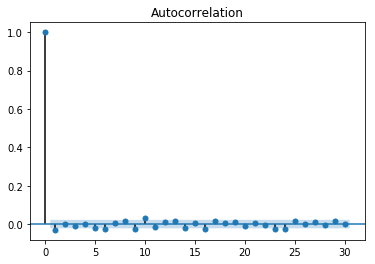

In [77]:
# Plotting the autocorrelation of the Price 
plot_acf(cad_jpy_returns, lags=30);

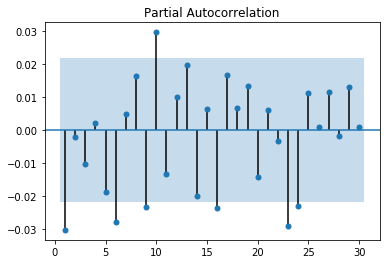

In [80]:
# Plotting the partial autocorrelation of the Price 
plot_pacf(cad_jpy_returns, zero=False, lags=30);

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  Price   No. Observations:                 7928
Model:                     ARMA(2, 1)   Log Likelihood               -9751.978
Method:                       css-mle   S.D. of innovations              0.828
Date:                Thu, 27 Jan 2022   AIC                          19513.955
Time:                        18:56:48   BIC                          19548.846
Sample:                             0   HQIC                         19525.903
                                                                              
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.0022      0.009     -0.245      0.807      -0.020       0.016
ar.L1.Price    -0.8547      0.164     -5.200      0.000      -1.177      -0.533
ar.L2.Price    -0.0197      0.013     -1.475      0.140      -0.046       0.006
ma.L1.Price     0.8246      0.164      5.030      0.000       0.503       1.146
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.2033           +0.0000j            1.2033            0.5000
AR.2          -42.1702           +0.0000j           42.1702            0.5000
MA.1           -1.2127           +0.0000j            1.2127            0.5000
-----------------------------------------------------------------------------
"""

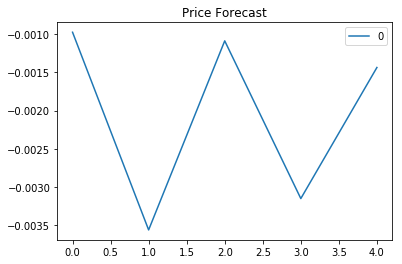

In [87]:
# Estimating ARMA model using statsmodels (order=(2, 1))
model = ARMA(cad_jpy_returns.Price, order=(2,1))

# Fitting the model and assigning it to a variable called results
cad_jpy_results_arma = model.fit()
# Plottig the forecasted return for the next 5 days
pd.DataFrame(cad_jpy_results_arma.forecast(steps=5)[0]).plot(title="Price Forecast")
cad_jpy_results_arma.summary()

**Question:** Based on the p-value, is the model a good fit?

**Answer:** The P-value is greater than the significance level, indicating the we cannot conclude that the coefficient is statistically significant

---

# Forecasting the Exchange Rate Price using an ARIMA Model

 1. Using the *raw* CAD/JPY exchange rate price, estimate an ARIMA model.
     1. Set P=5, D=1, and Q=1 in the model (e.g., ARIMA(df, order=(5,1,1))
     2. P= # of Auto-Regressive Lags, D= # of Differences (this is usually =1), Q= # of Moving Average Lags
 2. Output the ARIMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
 3. Plot a 5 day forecast for the Exchange Rate Price. What does the model forecast predict will happen to the Japanese Yen in the near term?

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Price   No. Observations:                 7928
Model:                 ARIMA(5, 1, 1)   Log Likelihood               -8745.622
Method:                       css-mle   S.D. of innovations              0.729
Date:                Thu, 27 Jan 2022   AIC                          17507.244
Time:                        19:15:47   BIC                          17563.070
Sample:                             1   HQIC                         17526.361
                                                                              
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0058      0.008     -0.743      0.458      -0.021       0.009
ar.L1.D.Price     0.4287      0.246      1.740      0.082      -0.054       0.912
ar.L2.D.Price     0.0177      0.014      1.264      0.206      -0.010       0.045
ar.L3.D.Price    -0.0118      0.012     -0.959      0.337      -0.036       0.012
ar.L4.D.Price     0.0110      0.012      0.879      0.379      -0.013       0.035
ar.L5.D.Price    -0.0191      0.011     -1.702      0.089      -0.041       0.003
ma.L1.D.Price    -0.4568      0.246     -1.856      0.064      -0.939       0.026
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.7660           -0.7702j            1.9266           -0.0655
AR.2            1.7660           +0.7702j            1.9266            0.0655
AR.3           -2.3649           -0.0000j            2.3649           -0.5000
AR.4           -0.2974           -2.4212j            2.4394           -0.2695
AR.5           -0.2974           +2.4212j            2.4394            0.2695
MA.1            2.1892           +0.0000j            2.1892            0.0000
-----------------------------------------------------------------------------
"""

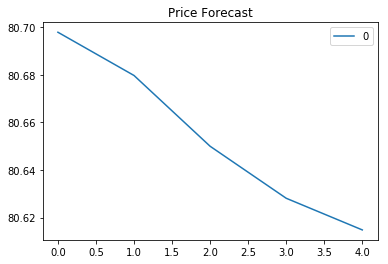

In [96]:
# Estimate and ARIMA Model:
# Hint: ARIMA(df, order=(p, d, q))
model = ARIMA(cad_jpy_erp.Price, order=(5, 1, 1))


# Fit the model
cad_jpy_results_arima = model.fit()
# Plot the Futures Price Forecast
pd.DataFrame(cad_jpy_results_arima.forecast(steps=5)[0]).plot(title="Price Forecast")
# Printing the model summary
cad_jpy_results_arima.summary()

**Question:** What does the model forecast will happen to the Japanese Yen in the near term?

**Answer:** The plot is indicating to us that it will take a consistent drop over the next 5 days, this drop will be very minor though going from, 80.70 to roughly 80.60

---

# Volatility Forecasting with GARCH

Rather than predicting returns, let's forecast near-term **volatility** of Japanese Yen exchange rate returns. Being able to accurately predict volatility will be extremely useful if we want to trade in derivatives or quantify our maximum loss.
 
Using exchange rate *Returns*, estimate a GARCH model. **Hint:** You can reuse the `returns` variable from the ARMA model section.

1. GARCH: Create an GARCH model and fit it to the returns data. Note: Set the parameters to p=2 and q=1: order=(2, 1).
2. Output the GARCH summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the volatility.

In [112]:
# Estimate a GARCH model:
arch_model(cad_jpy_returns['Price'], mean="Zero", vol="GARCH", p=2, q=1)


# Fit the model
res = model.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 46548.40924082976
Iteration:      2,   Func. Count:     16,   Neg. LLF: 306850859.3384427
Iteration:      3,   Func. Count:     22,   Neg. LLF: 8928.838861417698
Iteration:      4,   Func. Count:     27,   Neg. LLF: 11771.663036006626
Iteration:      5,   Func. Count:     33,   Neg. LLF: 10426.31072801688
Iteration:      6,   Func. Count:     41,   Neg. LLF: 8916.369930732108
Iteration:      7,   Func. Count:     47,   Neg. LLF: 8911.112105819691
Iteration:      8,   Func. Count:     52,   Neg. LLF: 8911.027322298947
Iteration:      9,   Func. Count:     57,   Neg. LLF: 8911.022077988246
Iteration:     10,   Func. Count:     62,   Neg. LLF: 8911.021067661106
Iteration:     11,   Func. Count:     67,   Neg. LLF: 8911.020797453917
Iteration:     12,   Func. Count:     72,   Neg. LLF: 8911.020764880363
Iteration:     13,   Func. Count:     76,   Neg. LLF: 8911.020764882265
Optimization terminated successfully    (Exit mode 0)
         

In [113]:
# Summarize the model results
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -8911.02
Distribution:                  Normal   AIC:                           17830.0
Method:            Maximum Likelihood   BIC:                           17858.0
                                        No. Observations:                 7928
Date:                Fri, Jan 28 2022   Df Residuals:                     7928
Time:                        18:57:57   Df Model:                            0
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      9.0733e-03  2.545e-03      3.566  3.628e-04  [4.086e-03,1.406e-02]
alpha[1]       0.0624  1.835e-02      3.402  6.682e-04  [2.647e-02,9.841e-02]
alpha[2]       0.0000  2.010e-02      0.000      1.000 [-3.940e-02,3.940e-02]
beta[1]        0.9243  1.229e-02     75.205      0.000      [  0.900,  0.948]
=============================================================================

Covariance estimator: robust
"""

**Note:** Our p-values for GARCH and volatility forecasts tend to be much lower than our ARMA/ARIMA return and price forecasts. In particular, here we have all p-values of less than 0.05, except for alpha(2), indicating overall a much better model performance. In practice, in financial markets, it's easier to forecast volatility than it is to forecast returns or prices. (After all, if we could very easily predict returns, we'd all be rich!)

In [106]:
# Find the last day of the dataset
last_day = cad_jpy_returns.index.max().strftime('%Y-%m-%d')
last_day

'2020-06-04'

In [107]:
# Create a 5 day forecast of volatility
forecast_horizon = 5

# Start the forecast using the last_day calculated above
forecast_horizon = res.forecast(start='2020-06-04', horizon=forecast_horizon)
forecast_horizon

In [109]:
# Annualize the forecast
intermediate = np.sqrt(forecast_horizon.variance.dropna() * 252)
intermediate.head()

,h.1,h.2,h.3,h.4,h.5
Date,,,,,
2020-06-04,12.566029,12.573718,12.581301,12.588778,12.596153


In [110]:
# Transpose the forecast so that it is easier to plot
final = intermediate.dropna().T
final.head()

Date,2020-06-04
h.1,12.566029
h.2,12.573718
h.3,12.581301
h.4,12.588778
h.5,12.596153


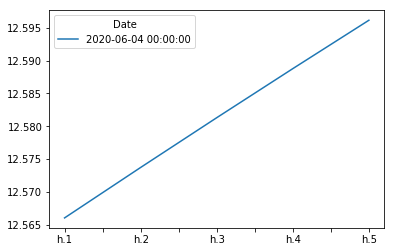

In [111]:
# Plot the final forecast
final.plot()

**Question:** What does the model forecast will happen to volatility in the near term?

**Answer:** The model is indicating a steap increase over the next 5 days. Although the amount is a minimal change as we can see it only goes from 12.565 to 12.595 even though the gradient is steap this is a small increase. 

---

# Conclusions

1. Based on your time series analysis, would you buy the yen now?

    * I would not cause as seen in this analysis the Yen is forecasted to decrease in the 5 coming days and the volatility is due to increase as well. I would consider buying maybe after the drop but for now no. 

2. Is the risk of the yen expected to increase or decrease?
    * The risk is expected to increase as the price will drop and the volatility will increase.

3. Based on the model evaluation, would you feel confident in using these models for trading?
    * I wouldn't be so comfortable with this model as the days for forecasting are low would make them higher, but from the outcomes they are a little insufficient in information the trading I like to do and the depth I like to evaluate. 